In [1]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
import pandas as pd

In [2]:
# pip install sklearn

In [3]:
import time
import tensorflow as tf
from tensorflow.compat.v1 import Session
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
from keras_frcnn import data_generators
from sklearn.metrics import average_precision_score
#from keras_frcnn import vgg as nn
from keras_frcnn.simple_parser import get_data
from keras_frcnn import resnet as nn

Using TensorFlow backend.


In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = Session(config=config)
bck_end = tf.compat.v1.keras.backend
bck_end.set_session(sess)

Device mapping:



In [5]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

In [6]:
def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

In [7]:
def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

In [8]:
# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [9]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	iou_result = 0
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	print(pred)
	print(pred_probs)
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou = 0
			iou = data_generators.iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			iou_result += iou
			print('IoU = ' + str(iou))
			if iou >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))
	for gt_box in gt:
		if not gt_box['bbox_matched']: # and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P, iou_result

In [10]:
def format_img_config_based(img, C):
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [11]:
#from keras_frcnn import vgg as nn
from keras_frcnn.simple_parser import get_data
from keras_frcnn import resnet as nn

In [12]:
#test_path = 'train_data'
#test_path = 'COCO_extracted_dataset/train_for_test'
test_path = 'y2bb_testing_MediumImage_AirPlane_annotate.txt'
img_path = test_path
config_output_filename = "./model_config_pickle/ytbb/y2bb_config_airplane_medium_images.pickle"

if not test_path:   # if filename is not given
	parser.error('Error: path to test data must be specified. Pass --path to command line')
    
# Create a config object and set the values
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

In [13]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

In [14]:
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)

{0: 'airplane', 1: 'bg'}


In [15]:
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
print(f' num_roi = {C.num_rois}')

 num_roi = 32


In [16]:
if C.network == 'resnet50':
	num_features = 1024
print(f' C.network = {C.network}')

 C.network = resnet50


In [17]:
if K.common.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (num_features, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, num_features)

In [18]:
img_input = Input(shape=input_shape_img)
img_input

<tf.Tensor 'input_1:0' shape=(None, None, None, 3) dtype=float32>

In [19]:
roi_input = Input(shape=(C.num_rois, 4))
roi_input

<tf.Tensor 'input_2:0' shape=(None, 32, 4) dtype=float32>

In [20]:
feature_map_input = Input(shape=input_shape_features)
feature_map_input

<tf.Tensor 'input_3:0' shape=(None, None, None, 1024) dtype=float32>

In [21]:
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

In [22]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
num_anchors

9

In [23]:
rpn_layers = nn.rpn(shared_layers, num_anchors)
rpn_layers

[<tf.Tensor 'rpn_out_class/Sigmoid:0' shape=(None, None, None, 9) dtype=float32>,
 <tf.Tensor 'rpn_out_regress/BiasAdd:0' shape=(None, None, None, 36) dtype=float32>,
 <tf.Tensor 'activation_40/Relu:0' shape=(None, None, None, 1024) dtype=float32>]

In [24]:
classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

In [25]:
class_mapping

{0: 'airplane', 1: 'bg'}

In [26]:
model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)
model_classifier = Model([feature_map_input, roi_input], classifier)

#### Evaluation results for COCO-YTBB with 5 epoch trained weights @Iou 50% and 75%

In [27]:
try:
	C.model_path = './model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0004.hdf5'
	print(f'Loading weights from {C.model_path}')
	model_rpn.load_weights(C.model_path, by_name=True)
	model_classifier.load_weights(C.model_path, by_name=True)    
	#model_rpn.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
	#model_classifier.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
except Exception as e:
	print(f'Couldnt load pre-trained model due to {repr(e)}')

Loading weights from ./coco_model_frcnn_airplane_vehicle_v1_0004.hdf5


In [28]:
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier_only.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [29]:
model_rpn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (FixedBatchNormalizati (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [30]:
model_classifier.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 4)        0                                            
__________________________________________________________________________________________________
roi_pooling_conv_1 (RoiPoolingC (None, 32, 14, 14, 1 0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
res5a_branch2a (TimeDistributed (None, 32, 7, 7, 512 524800      roi_pooling_conv_1[0][0]   

In [31]:
model_classifier_only.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 32, 4)        0                                            
__________________________________________________________________________________________________
roi_pooling_conv_1 (RoiPoolingC (None, 32, 14, 14, 1 0           input_3[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
res5a_branch2a (TimeDistributed (None, 32, 7, 7, 512 524800      roi_pooling_conv_1[0][0]   

In [30]:
test_imgs, _, _ = get_data(test_path)

Parsing annotation files


In [31]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

In [32]:
def append_predict_result(model_eval_result,image_id,predict_bbox,gt_bbox,iou_threshold,t,p,iou,ap,mAP):
    model_eval_result_1 = model_eval_result.append({"ImageID":image_id, "predict_bbox":predict_bbox, "gt_bbox": gt_bbox, "IoU_threshold":iou_threshold,"T":t, "P":p, "IoU":iou, "ap":ap,"mAP":mAP},ignore_index= True) 
    return model_eval_result_1

In [33]:
def evaluate_model(test_imgs,iou_threshold,C,model_rpn,model_classifier_only,model_evaluation_report_name):
    begin = time.time()
    T = {}
    P = {}
    iou_result = 0
    
    # store the test results
    model_eval_result = pd.DataFrame(columns=["ImageID","predict_bbox","gt_bbox","IoU_threshold","T","P","IoU","ap","mAP"])
    
    for idx, img_data in enumerate(test_imgs):
        print('{}/{}'.format(idx + 1,len(test_imgs)))
        st = time.time()
        filepath = img_data['filepath']

        img = cv2.imread(filepath)

        X, fx, fy = format_img_config_based(img, C)

        if K.common.image_dim_ordering() == 'tf':
            X = np.transpose(X, (0, 2, 3, 1))

        # get the feature maps and output from the RPN
        [Y1, Y2, F] = model_rpn.predict(X)


        R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.common.image_dim_ordering(), overlap_thresh= iou_threshold)


        # convert from (x1,y1,x2,y2) to (x,y,w,h)
        R[:, 2] -= R[:, 0]
        R[:, 3] -= R[:, 1]

        # apply the spatial pyramid pooling to the proposed regions
        bboxes = {}
        probs = {}

        for jk in range(R.shape[0] // C.num_rois + 1):
            ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
            if ROIs.shape[1] == 0:
                break

            if jk == R.shape[0] // C.num_rois:
                # pad R
                curr_shape = ROIs.shape
                target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
                ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                ROIs_padded[:, :curr_shape[1], :] = ROIs
                ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                ROIs = ROIs_padded

            [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

            for ii in range(P_cls.shape[1]):

                if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                    continue

                cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

                if cls_name not in bboxes:
                    bboxes[cls_name] = []
                    probs[cls_name] = []

                (x, y, w, h) = ROIs[0, ii, :]

                cls_num = np.argmax(P_cls[0, ii, :])
                try:
                    (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                    tx /= C.classifier_regr_std[0]
                    ty /= C.classifier_regr_std[1]
                    tw /= C.classifier_regr_std[2]
                    th /= C.classifier_regr_std[3]
                    x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
                except:
                    pass
                bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
                probs[cls_name].append(np.max(P_cls[0, ii, :]))

        all_dets = []

        for key in bboxes:
            bbox = np.array(bboxes[key])

            new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh= iou_threshold)
            for jk in range(new_boxes.shape[0]):
                (x1, y1, x2, y2) = new_boxes[jk, :]
                det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
                all_dets.append(det)


        print('Elapsed time = {}'.format(time.time() - st))
        t, p, iou = get_map(all_dets, img_data['bboxes'], (fx, fy))
        iou_result += iou
        for key in t.keys():
            print(f'key = {key}')
            if key not in T:
                T[key] = []
                P[key] = []
            T[key].extend(t[key])
            P[key].extend(p[key])
        all_aps = []
        for key in T.keys():
            ap = average_precision_score(T[key], P[key])
            print('{} AP: {}'.format(key, ap))
            all_aps.append(ap)
        print('mAP = {}'.format(np.mean(np.array(all_aps))))
        mAP = np.mean(np.array(all_aps))
        model_eval_result = append_predict_result(model_eval_result,filepath,all_dets,img_data['bboxes'],iou_threshold,T,P,iou,all_aps,mAP)
        
        print(T)
        print(P)
    print('Completely Elapsed time = {}'.format(time.time() - begin))
    iou_mean = iou_result/len(test_imgs)
    print(f'IoU@{iou_threshold} = ' + str(iou_mean))
    model_eval_result.to_csv(model_evaluation_report_name)
    print(f'###### saved model evaluation report {model_evaluation_report_name}')
    return model_eval_result,iou_mean

In [34]:
def show_model_evaluation_result(model_eval_result,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name):
    print(f'###### displaying the model evaluation result for object class = {class_name} @iou_threshold = {iou_threshold}')
    T = model_eval_result['T']
    T_New = T[0][class_name]
    print(f'###### True probability = {T_New}')
    P = model_eval_result['P']
    P_New = P[0][class_name]
    print(f'###### Predict probability = {P_New}')
    y_true = np.array(T_New)
    y_scores = np.array(P_New)
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    show_evaluation_plot(recall,precision,xlabel,ylabel,title,save_fig_name)

In [35]:
def show_evaluation_plot(recall, precision, xlabel, ylabel, title, save_fig_name):
    plt.figure(1)
    plt.plot(recall, precision)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(save_fig_name)

In [38]:
iou_threshold = 0.50
model_evaluation_report_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result_iou_' + str(iou_threshold) + '_medium_images.csv'
model_eval_result, IoU = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/19
Elapsed time = 5.607679128646851
[]
[]
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1]}
{'airplane': [0]}
2/19
Elapsed time = 2.701366901397705
[{'x1': 144, 'x2': 592, 'y1': 160, 'y2': 256, 'class': 'airplane', 'prob': 0.9189571}, {'x1': 240, 'x2': 448, 'y1': 160, 'y2': 256, 'class': 'airplane', 'prob': 0.50163853}]
[0.9189571  0.50163853]
IoU = 0.21212140624506792
IoU = 0.35017272456045095
key = airplane
airplane AP: 0.5
mAP = 0.5
{'airplane': [1, 0, 0, 1]}
{'airplane': [0, 0.9189571, 0.50163853, 0]}
3/19
Elapsed time = 2.6720492839813232
[]
[]
key = airplane
airplane AP: 0.6
mAP = 0.6
{'airplane': [1, 0, 0, 1, 1]}
{'airplane': [0, 0.9189571, 0.50163853, 0, 0]}
4/19
Elapsed time = 2.622760772705078
[{'x1': 16, 'x2': 336, 'y1': 112, 'y2': 208, 'class': 'airplane', 'prob': 0.90417534}, {'x1': 96, 'x2': 304, 'y1': 160, 'y2': 224, 'class': 'airplane', 'prob': 0.6748123}]
[0.90417534 0.6748123 ]
IoU = 0.18795325649800865
IoU = 0.5054310839995317
key = airplane
airplane AP: 

In [39]:
model_eval_result

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 111.412, 'x2': 21...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0,[1.0],1.000000
1,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 144, 'x2': 592, 'y1': 160, 'y2': 256, ...","[{'class': 'airplane', 'x1': 176.64, 'x2': 357...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0.562294,[0.5],0.500000
2,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 149.12, 'x2': 238...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0,[0.6],0.600000
3,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 16, 'x2': 336, 'y1': 112, 'y2': 208, '...","[{'class': 'airplane', 'x1': 132.84, 'x2': 258...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0.693384,[0.5119047619047619],0.511905
4,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 127.68, 'x2': 229...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0,[0.5666666666666667],0.566667
5,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 129.6000000000000...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0,[0.6111111111111112],0.611111
6,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 228.4800000000000...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0,[0.6476190476190475],0.647619
7,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 192, 'x2': 416, 'y1': 144, 'y2': 192, ...","[{'class': 'airplane', 'x1': 168.96, 'x2': 336...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0.683761,[0.7329545454545454],0.732955
8,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 320, 'x2': 384, 'y1': 176, 'y2': 208, ...","[{'class': 'airplane', 'x1': 257.76, 'x2': 356...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0.343909,[0.694017094017094],0.694017
9,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 160, 'x2': 496, 'y1': 192, 'y2': 304, ...","[{'class': 'airplane', 'x1': 152.3200000000000...",0.5,"{'airplane': [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,...","{'airplane': [0, 0.9189571, 0.50163853, 0, 0, ...",0.417514,[0.6733333333333333],0.673333


In [40]:
print(f' IoU @ {iou_threshold} threshold = {IoU}')

 IoU @ 0.5 threshold = 0.283324192935994


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.5
###### True probability = [1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1]
###### Predict probability = [0, 0.9189571, 0.50163853, 0, 0, 0.90417534, 0.6748123, 0, 0, 0, 0.96985406, 0.7373544, 0, 0.55528617, 0, 0.5491391, 0, 0.6298901, 0, 0.7629292, 0, 0.9891263, 0.8928533, 0.9764989, 0, 0, 0, 0.63060516, 0]


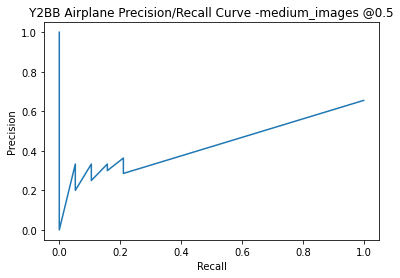

In [41]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'Y2BB Airplane Precision/Recall Curve -medium_images @' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_medium_images.png'
show_model_evaluation_result(model_eval_result,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)

In [42]:
iou_threshold = 0.75
model_evaluation_report_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result_iou_' + str(iou_threshold) + '_medium_images.csv'
model_eval_result_1,IoU_1 = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/19
Elapsed time = 3.880887508392334
[{'x1': 272, 'x2': 432, 'y1': 96, 'y2': 160, 'class': 'airplane', 'prob': 0.54488575}]
[0.54488575]
IoU = 0.2474818799374383
key = airplane
airplane AP: 0.5
mAP = 0.5
{'airplane': [0, 1]}
{'airplane': [0.54488575, 0]}
2/19
Elapsed time = 4.343230962753296
[{'x1': 144, 'x2': 592, 'y1': 160, 'y2': 256, 'class': 'airplane', 'prob': 0.9189571}, {'x1': 192, 'x2': 512, 'y1': 160, 'y2': 240, 'class': 'airplane', 'prob': 0.81686324}, {'x1': 224, 'x2': 448, 'y1': 160, 'y2': 256, 'class': 'airplane', 'prob': 0.62393254}]
[0.9189571  0.81686324 0.62393254]
IoU = 0.21212140624506792
IoU = 0.35636396248607966
IoU = 0.36829987220766264
key = airplane
airplane AP: 0.3333333333333333
mAP = 0.3333333333333333
{'airplane': [0, 1, 0, 0, 0, 1]}
{'airplane': [0.54488575, 0, 0.9189571, 0.81686324, 0.62393254, 0]}
3/19
Elapsed time = 3.9575376510620117
[{'x1': 224, 'x2': 384, 'y1': 208, 'y2': 256, 'class': 'airplane', 'prob': 0.70721805}]
[0.70721805]
IoU = 0.52202529459

Elapsed time = 3.2524144649505615
[{'x1': 144, 'x2': 304, 'y1': 240, 'y2': 304, 'class': 'airplane', 'prob': 0.9916495}, {'x1': 144, 'x2': 304, 'y1': 224, 'y2': 288, 'class': 'airplane', 'prob': 0.9764989}, {'x1': 144, 'x2': 304, 'y1': 240, 'y2': 288, 'class': 'airplane', 'prob': 0.94563097}]
[0.9916495  0.9764989  0.94563097]
IoU = 0.37355955198065843
IoU = 0.33641558914899417
IoU = 0.32680088445432987
key = airplane
airplane AP: 0.34981760929129346
mAP = 0.34981760929129346
{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]}
{'airplane': [0.54488575, 0, 0.9189571, 0.81686324, 0.62393254, 0, 0.70721805, 0.8440505, 0.7228143, 0.6848203, 0.66312927, 0.6056253, 0, 0.55070686, 0, 0.76170045, 0, 0.9765107, 0.9069129, 0.7373544, 0, 0.7807806, 0.5578599, 0.55528617, 0.5491391, 0, 0.93411756, 0.6298901, 0.54068863, 0.6849688, 0.7629292, 0, 0.99192894, 0.94133836, 0.8928533, 0.9916495, 0.9764989, 0.94563097, 0]}
17

In [43]:
model_eval_result_1

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 272, 'x2': 432, 'y1': 96, 'y2': 160, '...","[{'class': 'airplane', 'x1': 111.412, 'x2': 21...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.247482,[0.5],0.500000
1,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 144, 'x2': 592, 'y1': 160, 'y2': 256, ...","[{'class': 'airplane', 'x1': 176.64, 'x2': 357...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.936785,[0.3333333333333333],0.333333
2,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 224, 'x2': 384, 'y1': 208, 'y2': 256, ...","[{'class': 'airplane', 'x1': 149.12, 'x2': 238...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.522025,[0.39682539682539686],0.396825
3,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 80, 'x2': 304, 'y1': 160, 'y2': 224, '...","[{'class': 'airplane', 'x1': 132.84, 'x2': 258...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",1.522874,[0.28076923076923077],0.280769
4,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 176, 'x2': 288, 'y1': 192, 'y2': 256, ...","[{'class': 'airplane', 'x1': 127.68, 'x2': 229...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.107249,[0.30666666666666664],0.306667
5,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 208, 'x2': 480, 'y1': 192, 'y2': 288, ...","[{'class': 'airplane', 'x1': 129.6000000000000...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.687449,[0.34722222222222227],0.347222
6,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 228.4800000000000...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.000000,[0.37745098039215685],0.377451
7,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 192, 'x2': 416, 'y1': 144, 'y2': 192, ...","[{'class': 'airplane', 'x1': 168.96, 'x2': 336...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.683761,[0.4766995614035088],0.476700
8,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 320, 'x2': 384, 'y1': 176, 'y2': 208, ...","[{'class': 'airplane', 'x1': 257.76, 'x2': 356...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.343909,[0.47089947089947093],0.470899
9,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 144, 'x2': 608, 'y1': 192, 'y2': 288, ...","[{'class': 'airplane', 'x1': 152.3200000000000...",0.75,"{'airplane': [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,...","{'airplane': [0.54488575, 0, 0.9189571, 0.8168...",0.814425,[0.4352380952380952],0.435238


In [44]:
print(f' IoU @ {iou_threshold} threshold = {IoU_1}')

 IoU @ 0.75 threshold = 0.5639534813907889


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.75
###### True probability = [0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1]
###### Predict probability = [0.54488575, 0, 0.9189571, 0.81686324, 0.62393254, 0, 0.70721805, 0.8440505, 0.7228143, 0.6848203, 0.66312927, 0.6056253, 0, 0.55070686, 0, 0.76170045, 0, 0.9765107, 0.9069129, 0.7373544, 0, 0.7807806, 0.5578599, 0.55528617, 0.5491391, 0, 0.93411756, 0.6298901, 0.54068863, 0.6849688, 0.7629292, 0, 0.99192894, 0.94133836, 0.8928533, 0.9916495, 0.9764989, 0.94563097, 0, 0.5517767, 0, 0.81680423, 0.51547015, 0, 0.79520726, 0.5660417, 0]


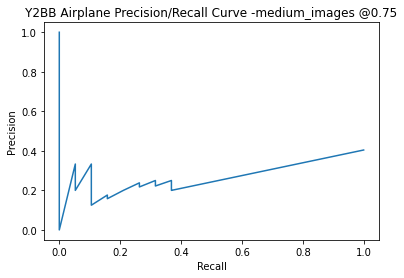

In [45]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'Y2BB Airplane Precision/Recall Curve -medium_images @' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_medium_images.png'
show_model_evaluation_result(model_eval_result_1,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)

#### Evaluation results for COCO-YTBB with 10 epoch trained weights @Iou 50% and 75%

In [36]:
try:
	C.model_path = './model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0009.hdf5'
	print(f'Loading weights from {C.model_path}')
	model_rpn.load_weights(C.model_path, by_name=True)
	model_classifier.load_weights(C.model_path, by_name=True)    
	#model_rpn.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
	#model_classifier.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
except Exception as e:
	print(f'Couldnt load pre-trained model due to {repr(e)}')

Loading weights from ./model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0009.hdf5


In [37]:
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier_only.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [38]:
iou_threshold = 0.50
model_evaluation_report_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result_iou_' + str(iou_threshold) + '_medium_images_10Epoch.csv'
model_eval_result, IoU = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/19
Elapsed time = 7.431503057479858
[]
[]
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1]}
{'airplane': [0]}
2/19
Elapsed time = 2.8250393867492676
[{'x1': 208, 'x2': 448, 'y1': 160, 'y2': 240, 'class': 'airplane', 'prob': 0.8858487}]
[0.8858487]
IoU = 0.46142739304242736
key = airplane
airplane AP: 0.6666666666666666
mAP = 0.6666666666666666
{'airplane': [1, 0, 1]}
{'airplane': [0, 0.8858487, 0]}
3/19
Elapsed time = 3.002147674560547
[{'x1': 240, 'x2': 368, 'y1': 208, 'y2': 272, 'class': 'airplane', 'prob': 0.9430193}]
[0.9430193]
IoU = 0.6082004240900353
key = airplane
airplane AP: 0.8333333333333333
mAP = 0.8333333333333333
{'airplane': [1, 0, 1, 1]}
{'airplane': [0, 0.8858487, 0, 0.9430193]}
4/19
Elapsed time = 2.846395492553711
[{'x1': 80, 'x2': 304, 'y1': 144, 'y2': 208, 'class': 'airplane', 'prob': 0.813985}]
[0.813985]
IoU = 0.39135833157456695
key = airplane
airplane AP: 0.75
mAP = 0.75
{'airplane': [1, 0, 1, 1, 0, 1]}
{'airplane': [0, 0.8858487, 0, 0.9430193, 0.8

In [39]:
model_eval_result

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 111.412, 'x2': 21...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0,[1.0],1.000000
1,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 208, 'x2': 448, 'y1': 160, 'y2': 240, ...","[{'class': 'airplane', 'x1': 176.64, 'x2': 357...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.461427,[0.6666666666666666],0.666667
2,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 240, 'x2': 368, 'y1': 208, 'y2': 272, ...","[{'class': 'airplane', 'x1': 149.12, 'x2': 238...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.6082,[0.8333333333333333],0.833333
3,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 80, 'x2': 304, 'y1': 144, 'y2': 208, '...","[{'class': 'airplane', 'x1': 132.84, 'x2': 258...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.391358,[0.75],0.750000
4,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 160, 'x2': 288, 'y1': 192, 'y2': 256, ...","[{'class': 'airplane', 'x1': 127.68, 'x2': 229...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.119172,[0.6],0.600000
5,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 224, 'x2': 448, 'y1': 208, 'y2': 288, ...","[{'class': 'airplane', 'x1': 129.6000000000000...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.865178,[0.7222222222222222],0.722222
6,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 228.4800000000000...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0,[0.7380952380952381],0.738095
7,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 168.96, 'x2': 336...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0,[0.7537878787878788],0.753788
8,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 288, 'x2': 384, 'y1': 176, 'y2': 208, ...","[{'class': 'airplane', 'x1': 257.76, 'x2': 356...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.415593,[0.7236467236467237],0.723647
9,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 208, 'x2': 480, 'y1': 208, 'y2': 304, ...","[{'class': 'airplane', 'x1': 152.3200000000000...",0.5,"{'airplane': [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,...","{'airplane': [0, 0.8858487, 0, 0.9430193, 0.81...",0.566794,[0.775],0.775000


In [40]:
print(f' IoU @ {iou_threshold} threshold = {IoU}')

 IoU @ 0.5 threshold = 0.36538154100925785


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.5
###### True probability = [1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1]
###### Predict probability = [0, 0.8858487, 0, 0.9430193, 0.813985, 0, 0.987148, 0, 0.99832386, 0, 0, 0.8844789, 0, 0.9987913, 0.68140525, 0, 0.94755673, 0.8174758, 0, 0.84227353, 0.5193255, 0.7604019, 0, 0.99917835, 0.9975084, 0, 0.9521756, 0, 0, 0.7573787, 0]


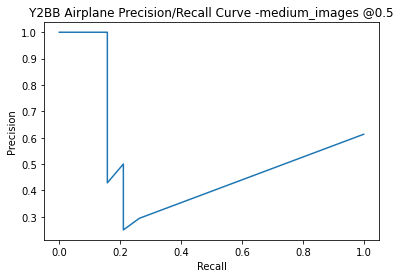

In [41]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'Y2BB Airplane Precision/Recall Curve -medium_images @' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_medium_images_10Epoch.png'
show_model_evaluation_result(model_eval_result,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)

In [42]:
iou_threshold = 0.75
model_evaluation_report_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result_iou_' + str(iou_threshold) + '_medium_images_10Epoch.csv'
model_eval_result_1,IoU_1 = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/19
Elapsed time = 4.2196080684661865
[]
[]
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1]}
{'airplane': [0]}
2/19
Elapsed time = 4.139119386672974
[{'x1': 208, 'x2': 464, 'y1': 160, 'y2': 240, 'class': 'airplane', 'prob': 0.99363375}, {'x1': 160, 'x2': 512, 'y1': 176, 'y2': 240, 'class': 'airplane', 'prob': 0.94840103}, {'x1': 224, 'x2': 416, 'y1': 160, 'y2': 240, 'class': 'airplane', 'prob': 0.80195445}, {'x1': 224, 'x2': 432, 'y1': 176, 'y2': 240, 'class': 'airplane', 'prob': 0.5589352}]
[0.99363375 0.94840103 0.80195445 0.5589352 ]
IoU = 0.4328398726550422
IoU = 0.3884820267361609
IoU = 0.5076439078268492
key = airplane
airplane AP: 0.3666666666666667
mAP = 0.3666666666666667
{'airplane': [1, 0, 0, 1, 0]}
{'airplane': [0, 0.99363375, 0.94840103, 0.80195445, 0.5589352]}
3/19
Elapsed time = 4.057574510574341
[{'x1': 240, 'x2': 368, 'y1': 208, 'y2': 272, 'class': 'airplane', 'prob': 0.9430193}, {'x1': 256, 'x2': 336, 'y1': 208, 'y2': 272, 'class': 'airplane', 'prob': 0.70

Elapsed time = 4.185736894607544
[{'x1': 144, 'x2': 304, 'y1': 192, 'y2': 240, 'class': 'airplane', 'prob': 0.99917835}, {'x1': 144, 'x2': 304, 'y1': 192, 'y2': 256, 'class': 'airplane', 'prob': 0.99584913}]
[0.99917835 0.99584913]
IoU = 0.6402451841254089
key = airplane
airplane AP: 0.5446200297287255
mAP = 0.5446200297287255
{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0]}
{'airplane': [0, 0.99363375, 0.94840103, 0.80195445, 0.5589352, 0.9430193, 0.7005787, 0.8594539, 0.813985, 0.6969439, 0, 0.987148, 0, 0.99832386, 0.98160535, 0, 0.9840036, 0.54236376, 0.9216223, 0.8844789, 0, 0.9987913, 0.96702, 0.8358974, 0.66346824, 0.68140525, 0, 0.968308, 0.96474695, 0.94755673, 0, 0.94354475, 0.9007801, 0.5804239, 0.5193255, 0.989301, 0.7604019, 0.99917835, 0.99584913]}
16/19
Elapsed time = 4.351704120635986
[{'x1': 144, 'x2': 320, 'y1': 240, 'y2': 288, 'class': 'airplane', 'prob': 0.9975606}, {'x1': 144, 'x2': 

In [43]:
model_eval_result_1

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 111.412, 'x2': 21...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0,[1.0],1.000000
1,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 208, 'x2': 464, 'y1': 160, 'y2': 240, ...","[{'class': 'airplane', 'x1': 176.64, 'x2': 357...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",1.32897,[0.3666666666666667],0.366667
2,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 240, 'x2': 368, 'y1': 208, 'y2': 272, ...","[{'class': 'airplane', 'x1': 149.12, 'x2': 238...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.6082,[0.42063492063492064],0.420635
3,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 16, 'x2': 304, 'y1': 128, 'y2': 208, '...","[{'class': 'airplane', 'x1': 132.84, 'x2': 258...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.838961,[0.3484848484848485],0.348485
4,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 160, 'x2': 288, 'y1': 192, 'y2': 256, ...","[{'class': 'airplane', 'x1': 127.68, 'x2': 229...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.119172,[0.33791208791208793],0.337912
5,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 224, 'x2': 448, 'y1': 208, 'y2': 288, ...","[{'class': 'airplane', 'x1': 129.6000000000000...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.865178,[0.47777777777777775],0.477778
6,Y2BB_extracted_dataset/airplane_for_test_mediu...,[],"[{'class': 'airplane', 'x1': 228.4800000000000...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0,[0.4880952380952381],0.488095
7,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 176, 'x2': 384, 'y1': 144, 'y2': 192, ...","[{'class': 'airplane', 'x1': 168.96, 'x2': 336...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.711518,[0.5132936507936507],0.513294
8,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 304, 'x2': 400, 'y1': 176, 'y2': 208, ...","[{'class': 'airplane', 'x1': 257.76, 'x2': 356...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.898871,[0.48941798941798936],0.489418
9,Y2BB_extracted_dataset/airplane_for_test_mediu...,"[{'x1': 208, 'x2': 480, 'y1': 208, 'y2': 304, ...","[{'class': 'airplane', 'x1': 152.3200000000000...",0.75,"{'airplane': [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,...","{'airplane': [0, 0.99363375, 0.94840103, 0.801...",0.566794,[0.5377777777777778],0.537778


In [44]:
print(f' IoU @ {iou_threshold} threshold = {IoU_1}')

 IoU @ 0.75 threshold = 0.5881749024333518


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.75
###### True probability = [1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]
###### Predict probability = [0, 0.99363375, 0.94840103, 0.80195445, 0.5589352, 0.9430193, 0.7005787, 0.8594539, 0.813985, 0.6969439, 0, 0.987148, 0, 0.99832386, 0.98160535, 0, 0.9840036, 0.54236376, 0.9216223, 0.8844789, 0, 0.9987913, 0.96702, 0.8358974, 0.66346824, 0.68140525, 0, 0.968308, 0.96474695, 0.94755673, 0, 0.94354475, 0.9007801, 0.5804239, 0.5193255, 0.989301, 0.7604019, 0.99917835, 0.99584913, 0.9975606, 0.9975084, 0.8398964, 0, 0.9521756, 0.86787903, 0, 0.7573787, 0.66919047, 0]


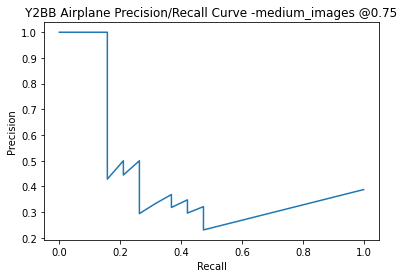

In [45]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'Y2BB Airplane Precision/Recall Curve -medium_images @' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-YTBB/AIRPLANE_CLASS/y2bb_images_coco_weights_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_medium_images_10Epoch.png'
show_model_evaluation_result(model_eval_result_1,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)